In [14]:
%cd '/app'

/app


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sys
sys.path.append('src')

### Loading border basis dataset 

In [17]:
import os
from pathlib import Path
from src.loader.data import load_data
from src.loader.data_format.processors.base import ProcessorChain
from src.loader.tokenizer import set_vocab, set_tokenizer

# load config
import yaml
with open('config/problems/border_basis.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set up vocab and tokenizer
vocab = set_vocab(
    num_vars=config['ring']['num_variables'],
    field=f"{config['field']['type']}{config['field']['param']}",
    max_coeff=config['polynomial']['coefficient']['max'],
    max_degree=config['polynomial']['max_degree']
)
tokenizer = set_tokenizer(vocab, max_seq_length=1000)

# data path
data_path = f"/app/data/border_basis/GF31_n={config['ring']['num_variables']}/test"

# load test dataset
test_dataset, data_collator = load_data(
    data_path=data_path,
    splits=[{"name": "test", "batch_size": 32, "shuffle": False}],
    tokenizer=tokenizer,
    return_dataloader=False
)

id = 2
input_text = test_dataset[id]['input']
target_text = test_dataset[id]['target']

print(input_text)
print(target_text)


C16 E0 E6 E0 + C26 E2 E3 E1 + C11 E1 E4 E1 + C4 E0 E5 E1 + C23 E1 E3 E2 + C5 E0 E4 E2 + C16 E1 E4 E0 + C7 E0 E5 E0 + C2 E1 E3 E1 + C5 E0 E4 E1 + C6 E1 E2 E2 + C13 E0 E3 E2 + C11 E1 E1 E3 + C7 E0 E2 E3 + C1 E0 E1 E4 + C12 E1 E3 E0 + C28 E0 E4 E0 + C21 E2 E1 E1 + C26 E1 E2 E1 + C13 E0 E3 E1 + C28 E1 E1 E2 + C2 E0 E2 E2 + C27 E0 E1 E3 + C8 E2 E1 E0 + C22 E1 E2 E0 + C7 E0 E3 E0 + C8 E2 E0 E1 + C11 E1 E1 E1 + C26 E0 E2 E1 + C20 E1 E0 E2 + C26 E0 E1 E2 + C28 E0 E0 E3 + C3 E1 E1 E0 + C9 E0 E2 E0 + C8 E1 E0 E1 + C6 E0 E1 E1 + C10 E1 E0 E0 + C14 E0 E1 E0 + C19 E0 E0 E1 + C22 E0 E0 E0 [SEP] C20 E3 E2 E0 + C16 E1 E4 E0 + C22 E1 E3 E1 + C1 E0 E2 E3 + C21 E3 E1 E0 + C28 E1 E3 E0 + C13 E0 E4 E0 + C10 E3 E0 E1 + C8 E1 E2 E1 + C5 E0 E3 E1 + C27 E0 E2 E2 + C10 E3 E0 E0 + C1 E2 E1 E0 + C27 E1 E2 E0 + C24 E0 E3 E0 + C22 E1 E1 E1 + C30 E0 E2 E1 + C28 E0 E1 E2 + C29 E2 E0 E0 + C12 E1 E1 E0 + C11 E0 E2 E0 + C15 E0 E1 E1 + C16 E0 E0 E2 + C7 E1 E0 E0 + C11 E0 E1 E0 + C16 E0 E0 E1 + C16 E0 E0 E0 [SEP] C11 E0 E

### Retrieve SageMath objects

In [18]:
from sage.all import *
from src.dataset.processors.utils import sequence_to_poly, poly_to_sequence, get_field

field_name = f"{config['field']['type']}{config['field']['param']}"
field = get_field(field_name)
# ring = PolynomialRing(field, ['x', 'y', 'z'], order='degrevlex')
ring = PolynomialRing(field, 'x', config['ring']['num_variables'], order='degrevlex')

F = [sequence_to_poly(f_text, ring) for f_text in input_text.split(' [SEP] ')]
BB = [sequence_to_poly(g_text, ring) for g_text in target_text.split(' [SEP] ')]

In [19]:
ideal(BB).variety()

[{x2: 29, x1: 15, x0: 8}, {x2: 26, x1: 10, x0: 28}, {x2: 14, x1: 22, x0: 30}]

In [20]:
ideal(BB) == ideal(F)

True

### Run border basis calculator

In [21]:
%%time 
from src.border_basis_lib.improved_border_basis import ImprovedBorderBasisCalculator

calculator = ImprovedBorderBasisCalculator(ring, corollary_23=True, N=100, save_universes=True, verbose=False)

use_fast_elimination = True  # use gaussian_elimination_fast
lstabilization_only = False  # only compute L-stable span

G, O, _ = calculator.compute_border_basis_optimized(F,
                                            use_fast_elimination=use_fast_elimination,
                                            lstabilization_only=lstabilization_only)

calculator.datasets[0][0]

CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 120 ms


[[x0^2*x2^2,
  x1*x2^4,
  x0^3*x1*x2,
  x0*x1^2*x2^3,
  x1^4*x2^2,
  x0*x1^3*x2^2,
  x1^5*x2,
  x0*x1^4*x2,
  x0^2*x1^3*x2,
  x1^6,
  x0^3*x1^3],
 [x1^6 - 10*x0^2*x1^3*x2 - 9*x0*x1^4*x2 + 8*x1^5*x2 + 15*x0*x1^3*x2^2 + 10*x1^4*x2^2 + x0*x1^4 + 14*x1^5 + 4*x0*x1^3*x2 + 10*x1^4*x2 + 12*x0*x1^2*x2^2 - 5*x1^3*x2^2 - 9*x0*x1*x2^3 + 14*x1^2*x2^3 + 2*x1*x2^4 - 7*x0*x1^3 - 6*x1^4 + 11*x0^2*x1*x2 - 10*x0*x1^2*x2 - 5*x1^3*x2 - 6*x0*x1*x2^2 + 4*x1^2*x2^2 - 8*x1*x2^3 - 15*x0^2*x1 + 13*x0*x1^2 + 14*x1^3 - 15*x0^2*x2 - 9*x0*x1*x2 - 10*x1^2*x2 + 9*x0*x2^2 - 10*x1*x2^2 - 6*x2^3 + 6*x0*x1 - 13*x1^2 - 15*x0*x2 + 12*x1*x2 - 11*x0 - 3*x1 + 7*x2 + 13,
  x0^3*x1^2 + 7*x0*x1^4 - 2*x0*x1^3*x2 + 14*x1^2*x2^3 + 15*x0^3*x1 - 11*x0*x1^3 - 4*x1^4 - 15*x0^3*x2 - 12*x0*x1^2*x2 + 8*x1^3*x2 + 6*x1^2*x2^2 - 15*x0^3 + 14*x0^2*x1 + 6*x0*x1^2 - 5*x1^3 - 2*x0*x1*x2 - 14*x1^2*x2 - 11*x1*x2^2 + 3*x0^2 + 13*x0*x1 - x1^2 - 7*x1*x2 + 7*x2^2 + 5*x0 - x1 + 7*x2 + 7,
  x0^2*x1^3*x2 - 3*x0*x1^4*x2 + 13*x1^5*x2 + 5*x0*x1^3*x2^2 - 11*

### Get expantion dataset 

In [22]:
'''
    calculator.datasets[0][0] gives
    (L,  # Geneators of the order ideal O(L)
     V,  # Target set of polynomials to span,
     S,  # # List of polynomials that were successfully extended
     )
     
     From this, we construct 
     input: 
     (F, L, V)
     output: 
     (S)  
     
     Note: 
     It would be better to put something like [SUPER_SEP] instead of [SEP] between F, L, V. 
'''


## Get one sample
L, V, S = calculator.datasets[0][0]
inputs = F + L + V
target = S

inputs_text = [poly_to_sequence(f) for f in inputs]
inputs_text = ' [SEP] '.join(inputs_text)
target_text = [poly_to_sequence(f) for f in target]
target_text = ' [SEP] '.join(target_text)

sample_text = ' # '.join([inputs_text, target_text])

sample_text

'C16 E0 E6 E0 + C26 E2 E3 E1 + C11 E1 E4 E1 + C4 E0 E5 E1 + C23 E1 E3 E2 + C5 E0 E4 E2 + C16 E1 E4 E0 + C7 E0 E5 E0 + C2 E1 E3 E1 + C5 E0 E4 E1 + C6 E1 E2 E2 + C13 E0 E3 E2 + C11 E1 E1 E3 + C7 E0 E2 E3 + C1 E0 E1 E4 + C12 E1 E3 E0 + C28 E0 E4 E0 + C21 E2 E1 E1 + C26 E1 E2 E1 + C13 E0 E3 E1 + C28 E1 E1 E2 + C2 E0 E2 E2 + C27 E0 E1 E3 + C8 E2 E1 E0 + C22 E1 E2 E0 + C7 E0 E3 E0 + C8 E2 E0 E1 + C11 E1 E1 E1 + C26 E0 E2 E1 + C20 E1 E0 E2 + C26 E0 E1 E2 + C28 E0 E0 E3 + C3 E1 E1 E0 + C9 E0 E2 E0 + C8 E1 E0 E1 + C6 E0 E1 E1 + C10 E1 E0 E0 + C14 E0 E1 E0 + C19 E0 E0 E1 + C22 E0 E0 E0 [SEP] C20 E3 E2 E0 + C16 E1 E4 E0 + C22 E1 E3 E1 + C1 E0 E2 E3 + C21 E3 E1 E0 + C28 E1 E3 E0 + C13 E0 E4 E0 + C10 E3 E0 E1 + C8 E1 E2 E1 + C5 E0 E3 E1 + C27 E0 E2 E2 + C10 E3 E0 E0 + C1 E2 E1 E0 + C27 E1 E2 E0 + C24 E0 E3 E0 + C22 E1 E1 E1 + C30 E0 E2 E1 + C28 E0 E1 E2 + C29 E2 E0 E0 + C12 E1 E1 E0 + C11 E0 E2 E0 + C15 E0 E1 E1 + C16 E0 E0 E2 + C7 E1 E0 E0 + C11 E0 E1 E0 + C16 E0 E0 E1 + C16 E0 E0 E0 [SEP] C11 E0 

In [23]:
## Collect all samples.

number_of_Lstabspan = len(calculator.datasets)

dataset = []
for i in range(number_of_Lstabspan):
    number_of_Lstabspan_iterations = len(calculator.datasets[i])
    for j in range(number_of_Lstabspan_iterations):
        L, V, S = calculator.datasets[i][j]
        
        inputs = F + L + V
        target = S

        inputs_text = [poly_to_sequence(f) for f in inputs]
        inputs_text = ' [SEP] '.join(inputs_text)
        target_text = [poly_to_sequence(f) for f in target]
        target_text = ' [SEP] '.join(target_text)

        sample_text = ' # '.join([inputs_text, target_text])

        dataset.append(sample_text)

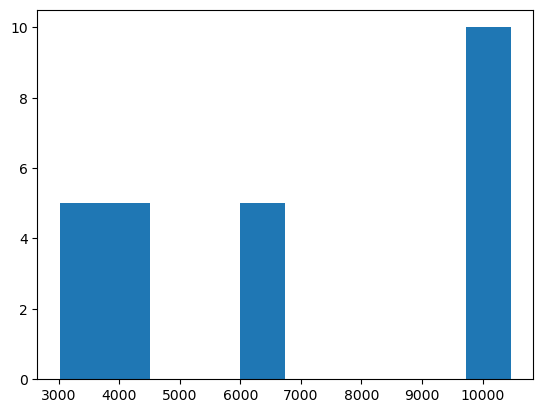

In [24]:
import matplotlib.pyplot as plt

ntokens = [len(sample.split()) for sample in dataset] # The number of tokens

plt.hist(ntokens)
plt.show()


### Examining the number of tokens

In [25]:
L, V, S = calculator.datasets[0][0]

print(f'L: {len(L)}, V: {len(V)}, S: {len(S)}')

L_lengths = [] 
for l in L: 
    length = len(poly_to_sequence(l).split())
    # print(length)
    L_lengths.append(length)

V_lengths = []
for v in V: 
    length = len(poly_to_sequence(v).split())
    # print(length)
    V_lengths.append(length)

S_lengths = []
for s in S: 
    length = len(poly_to_sequence(s).split())
    # print(length)
    S_lengths.append(length)

import numpy as np 
print(f'#tokens in L: {np.mean(L_lengths)}, {np.std(L_lengths)}, {np.min(L_lengths)}, {np.max(L_lengths)}')
print(f'#tokens in V: {np.mean(V_lengths)}, {np.std(V_lengths)}, {np.min(V_lengths)}, {np.max(V_lengths)}')
print(f'#tokens in S: {np.mean(S_lengths)}, {np.std(S_lengths)}, {np.min(S_lengths)}, {np.max(S_lengths)}')


L: 11, V: 8, S: 7
#tokens in L: 4.0, 0.0, 4, 4
#tokens in V: 145.875, 45.957691140874346, 64, 219
#tokens in S: 99.71428571428571, 34.5820526768863, 64, 159


In [12]:
L

[x1^3*x2^2,
 x0*x1^2*x2^2,
 x1^4*x2,
 x0*x1^3*x2,
 x0^2*x1^2*x2,
 x0^3*x1*x2,
 x0^4*x2,
 x1^5,
 x0*x1^4,
 x0^2*x1^3,
 x0^3*x1^2,
 x0^4*x1,
 x0^5,
 x2^6,
 x1*x2^5,
 x0*x2^5,
 x1^2*x2^4,
 x0*x1*x2^4,
 x0^2*x2^4,
 x0^2*x1*x2^3,
 x0^3*x2^3]

In [44]:
V

[x0*x1^4 - 13*x0^4*x2 + 10*x0^3*x1*x2 - 6*x0^2*x1*x2^2 - 6*x0^2*x2^3 + 3*x1^2*x2^3 - 14*x0^4 + 10*x0^3*x1 - 10*x0^2*x1^2 - 12*x0*x1^3 - x0^3*x2 + 15*x0^2*x1*x2 - 3*x0*x1^2*x2 - 11*x1^3*x2 + 4*x0^2*x2^2 + 14*x0*x1*x2^2 + 6*x1^2*x2^2 - 9*x0*x2^3 + 10*x1*x2^3 + 4*x2^4 - x0^3 + 10*x0^2*x1 + 6*x0*x1^2 - 15*x1^3 - 6*x0^2*x2 + 6*x0*x1*x2 + 10*x1^2*x2 - 7*x0*x2^2 + 15*x2^3 + x0^2 - 13*x0*x1 + 5*x1^2 - 4*x0*x2 - 12*x1*x2 + 4*x2^2 - 7*x0 - 5*x1 + 6*x2 + 4,
 x0^2*x1^3 + 2*x0^2*x1^2*x2 - 12*x0^2*x1*x2^2 + 5*x0*x1^2*x2^2 - 15*x1^3*x2^2 - 15*x0^3*x1 - 10*x0^2*x1^2 - 9*x0*x1^3 - 12*x1^4 + x0^2*x1*x2 - 10*x0*x1^2*x2 - 3*x1^3*x2 - 9*x0*x1*x2^2 - 8*x1^2*x2^2 + 5*x0*x2^3 + 2*x1*x2^3 + x0^2*x1 - 13*x0*x1^2 - 3*x1^3 - 11*x0^2*x2 - 7*x0*x1*x2 + 12*x1^2*x2 + 14*x0*x2^2 + 8*x1*x2^2 - x2^3 + 11*x0^2 - 13*x0*x1 - x1^2 - 7*x0*x2 + 4*x1*x2 - 4*x2^2 + 12*x0 - 3*x1 - 2*x2 - 6,
 x0^2*x1^2 + 12*x0*x1^3 + 2*x0^3*x2 + 5*x0*x1^2*x2 - 3*x0^2*x2^2 - 12*x1^2*x2^2 + 9*x0*x2^3 + 4*x0^3 + 6*x0^2*x1 + 12*x0*x1^2 - 15*x1^3 + 2*

In [45]:
BB

[x0^2 + 11*x0 - 12*x1 - 11*x2 + 13,
 x0*x1 + 9*x0 + 8*x1 + 6*x2 - 12,
 x1^2 + 5*x0 - 12*x1 + 8*x2 + 6,
 x0*x2 + 13*x0 + 14*x1 + 12*x2 + 7,
 x1*x2 + 8*x0 + 5*x1 + x2 - 13,
 x2^2 - 14*x0 - 14*x1 + 2*x2 + 5]

In [46]:
G

[x2^2 - 14*x0 - 14*x1 + 2*x2 + 5,
 x1*x2 + 8*x0 + 5*x1 + x2 - 13,
 x0*x2 + 13*x0 + 14*x1 + 12*x2 + 7,
 x1^2 + 5*x0 - 12*x1 + 8*x2 + 6,
 x0*x1 + 9*x0 + 8*x1 + 6*x2 - 12,
 x0^2 + 11*x0 - 12*x1 - 11*x2 + 13]

`BB`: The border basis in the original dataset

`G` : The computed border basis by improved border basis algorithm

- Two bases are different (probably because of some sorting). 
- But they generate the same ideals, so it's fine. 


In [47]:
ideal(G) == ideal(BB)
# ideal(G) == ideal(F)  # also good

True

In [48]:
O

[1, x2, x1, x0]

The order ideal and border basis contains terms upto degree 3. However, `L` and `V` contains very high degree terms -- is that reasonable? 

In [49]:
L

[x2^4,
 x1^2*x2^3,
 x0^2*x2^3,
 x1^3*x2^2,
 x0*x1^2*x2^2,
 x0^2*x1*x2^2,
 x0^2*x1^2*x2,
 x0^3*x1*x2,
 x0^4*x2,
 x0*x1^4,
 x0^2*x1^3,
 x0^4*x1]

In [52]:
from src.border_basis_lib.utils import is_order_ideal

is_order_ideal(L)

False

In [57]:
L, V, S = calculator.datasets[3][0]
L

[x0^3*x1^2,
 x0^2*x1^2*x2^2,
 x0^3*x1*x2^2,
 x0^4*x2^2,
 x1^5*x2,
 x0*x1^4*x2,
 x0^2*x1^3*x2,
 x0^5*x2,
 x1^6,
 x0*x1^5,
 x0^5*x1,
 x0^6,
 x0*x2^6,
 x1^2*x2^5,
 x0*x1*x2^5,
 x0^2*x2^5,
 x1^3*x2^4,
 x0*x1^2*x2^4,
 x0^2*x1*x2^4,
 x0^3*x2^4,
 x1^4*x2^3,
 x0*x1^3*x2^3]